# Predição de casos de Covid-19 no Brasil

### Dataset utilizado:
* Número de casos confirmados de COVID-19 no Brasil
* Diponível em: https://github.com/wcota/covid19br
* DOI: 10.1590/SciELOPreprints.362

### Importações

In [51]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot
import seaborn as sns
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

### Lendo os dados

In [52]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
dataframe = pd.read_csv('drive/MyDrive/cases-brazil-cities-time.csv', header=0, parse_dates=['date'])

### Verificando a quantidade de registros do dataset

In [54]:
dataframe.shape

(1381597, 17)

In [55]:
dataframe

,epi_week,date,country,state,city,ibgeID,cod_RegiaoDeSaude,name_RegiaoDeSaude,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
0,9,2020-02-25,Brazil,SP,São Paulo/SP,3550308,35016.0,São Paulo,0,0,1,1,0.00000,0.00811,0.00000,SES,2021-01-11
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,1,1,0.00000,0.00047,0.00000,NaN,NaN
2,9,2020-02-26,Brazil,SP,São Paulo/SP,3550308,35016.0,São Paulo,0,0,0,1,0.00000,0.00811,0.00000,SES,2021-01-11
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,0,1,0.00000,0.00047,0.00000,NaN,NaN
4,9,2020-02-27,Brazil,SP,São Paulo/SP,3550308,35016.0,São Paulo,0,0,0,1,0.00000,0.00811,0.00000,SES,2021-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381592,102,2021-01-12,Brazil,PR,Ângulo/PR,4101150,41015.0,15ª RS Maringá,0,2,0,122,68.25939,4163.82253,0.01639,SES,2021-01-12
1381593,102,2021-01-12,Brazil,BA,Érico Cardoso/BA,2900504,29003.0,Brumado,0,2,5,106,18.93939,1003.78788,0.01887,MS,2021-01-12
1381594,102,2021-01-12,Brazil,PA,Óbidos/PA,1505106,15002.0,Baixo Amazonas,0,47,0,3365,89.85585,6433.29637,0.01397,SES,2021-01-12
1381595,102,2021-01-12,Brazil,SP,Óleo/SP,3533809,35094.0,Ourinhos,0,0,0,6,0.00000,242.81667,0.00000,MS,2021-01-12


### Removendo os dados de Estados

In [56]:
# Iremos trabalhar apenas com os números nacionais
dataframe = dataframe[dataframe.state == 'TOTAL']
dataframe

,epi_week,date,country,state,city,ibgeID,cod_RegiaoDeSaude,name_RegiaoDeSaude,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,_source,last_info_date
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,1,1,0.00000,0.00047,0.00000,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,0,1,0.00000,0.00047,0.00000,NaN,NaN
5,9,2020-02-27,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,0,1,0.00000,0.00047,0.00000,NaN,NaN
7,9,2020-02-28,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,1,2,0.00000,0.00094,0.00000,NaN,NaN
9,9,2020-02-29,Brazil,TOTAL,TOTAL,0,NaN,NaN,0,0,0,2,0.00000,0.00094,0.00000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359209,101,2021-01-08,Brazil,TOTAL,TOTAL,0,NaN,NaN,1107,201786,62852,8032964,95.29189,3793.50558,0.02512,NaN,NaN
1364805,101,2021-01-09,Brazil,TOTAL,TOTAL,0,NaN,NaN,983,202769,48127,8081091,95.75610,3816.23319,0.02509,NaN,NaN
1370402,102,2021-01-10,Brazil,TOTAL,TOTAL,0,NaN,NaN,490,203259,29027,8110118,95.98750,3829.94097,0.02506,NaN,NaN
1375999,102,2021-01-11,Brazil,TOTAL,TOTAL,0,NaN,NaN,491,203750,30747,8140865,96.21937,3844.46100,0.02503,NaN,NaN


In [57]:
# Obtem apenas os dados de novos casos
dataframe_novos_casos = dataframe[["date", "newCases"]].set_index("date")
series = dataframe_novos_casos["newCases"]
series

date
2020-02-25        1
2020-02-26        0
2020-02-27        0
2020-02-28        1
2020-02-29        0
              ...  
2021-01-08    62852
2021-01-09    48127
2021-01-10    29027
2021-01-11    30747
2021-01-12    62529
Name: newCases, Length: 323, dtype: int64

In [58]:
type(series)

pandas.core.series.Series

In [59]:
series.describe()

count      323.000000
mean     25397.845201
std      18267.720303
min          0.000000
25%      10172.000000
50%      24454.000000
75%      39533.000000
max      87969.000000
Name: newCases, dtype: float64

### Visualizando os dados

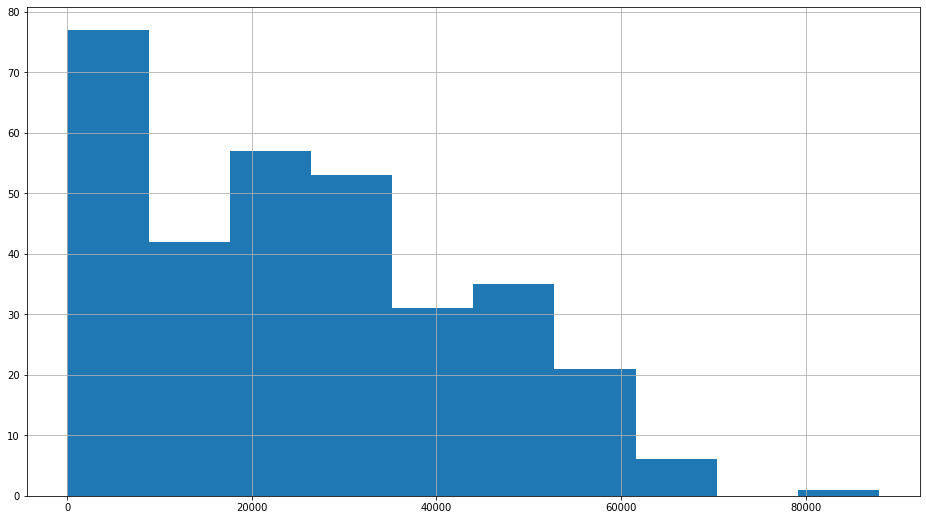

In [60]:
series.hist(figsize=(16,9))
pyplot.show()

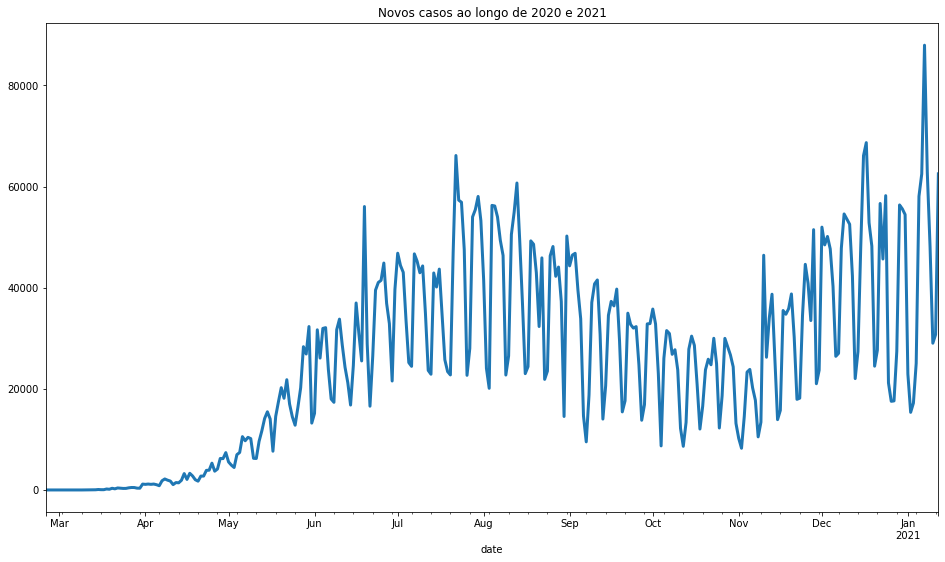

In [61]:
# Novos casos ao longo de 2020 e 2021
series.plot(figsize=(16,9),  
            fontsize=10,
            linewidth=3,
            title='Novos casos ao longo de 2020 e 2021')
pyplot.show()

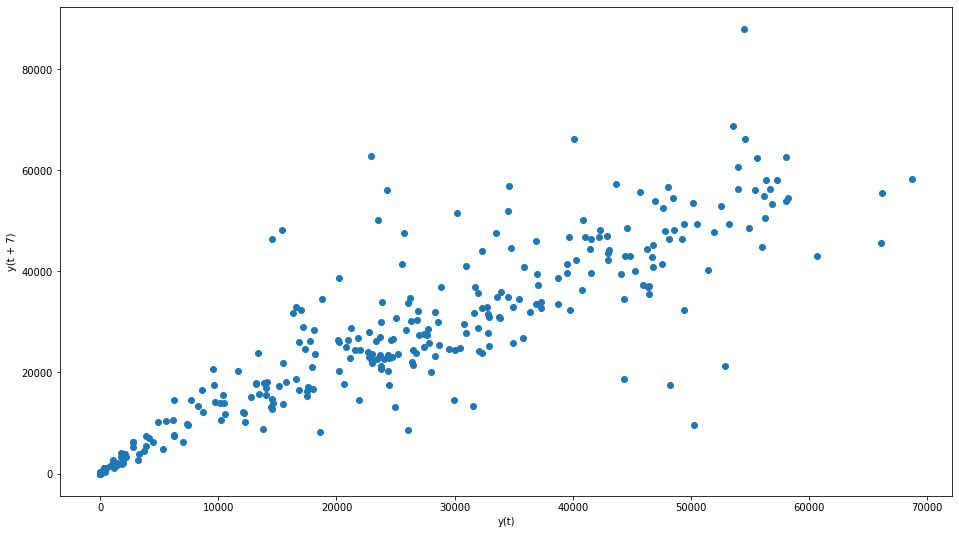

In [62]:
# Dispersão de valores e lags
pyplot.figure(figsize = (16,9))
lag_plot(series, lag=7)
pyplot.show()

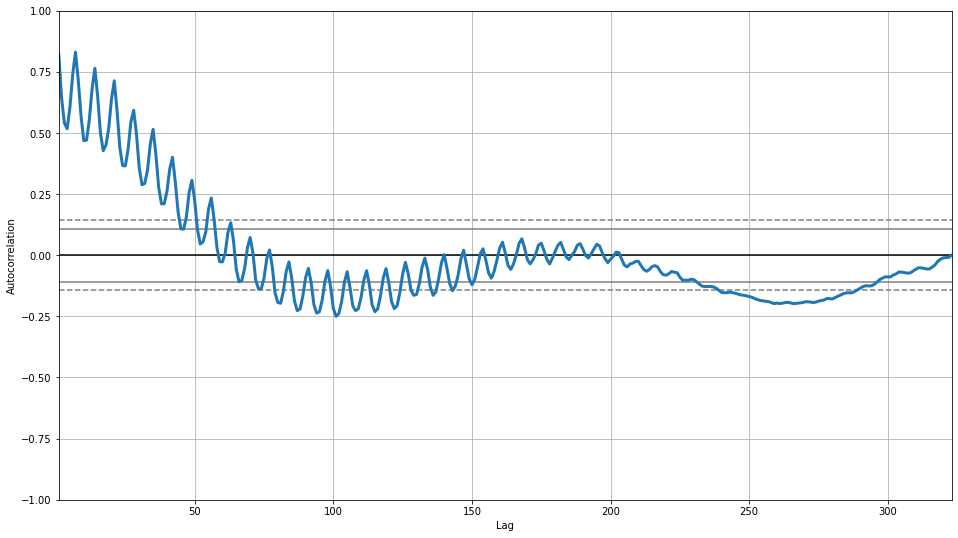

In [63]:
# Autocorrelação entre os lags
pyplot.figure(figsize = (16,9))
autocorrelation_plot(series, linewidth=3)
pyplot.show()

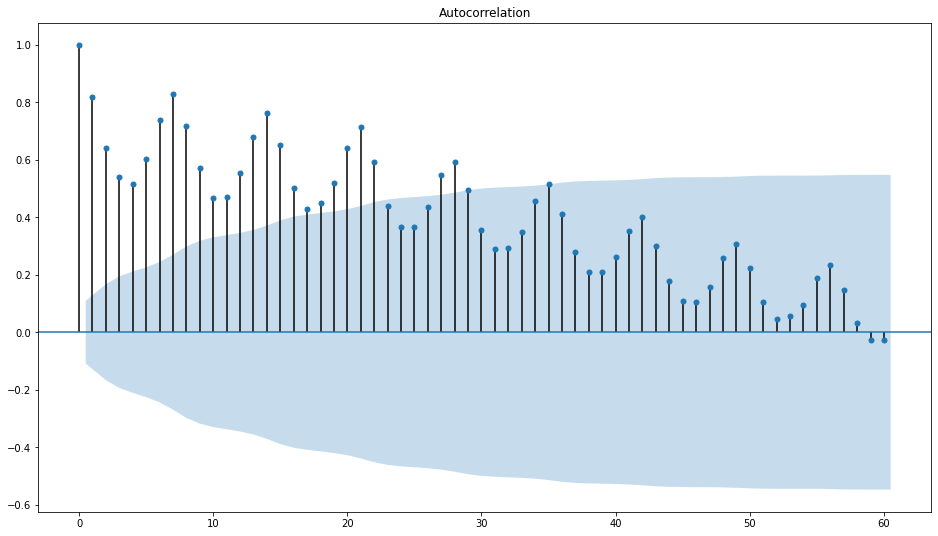

In [64]:
# Autocorrelação com Statsmodels
# Calcula a correlação com lags
pyplot.rc("figure", figsize=(16,9))
plot_acf(series, lags=60)
pyplot.show()

In [65]:
# Análise de novos casos por mês
resample = series.resample('M')
novos_casos_mes = resample.mean()

In [66]:
novos_casos_mes

date
2020-02-29        0.400000
2020-03-31      188.774194
2020-04-30     2712.666667
2020-05-31    13839.129032
2020-06-30    29884.400000
2020-07-31    40573.612903
2020-08-31    40141.225806
2020-09-30    30084.533333
2020-10-31    23238.645161
2020-11-30    26806.733333
2020-12-31    43195.709677
2021-01-31    43530.166667
Freq: M, Name: newCases, dtype: float64

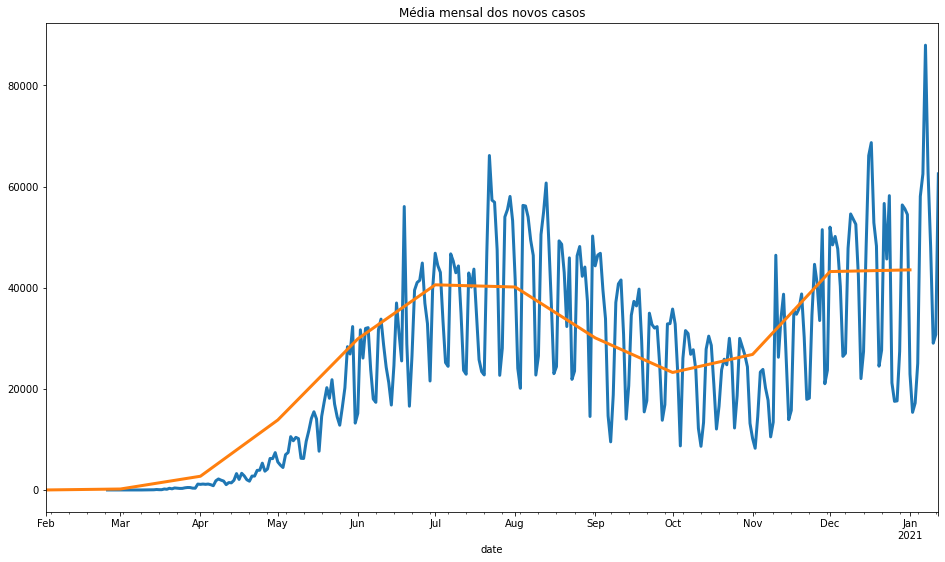

In [67]:
# Média mensal dos novos casos (gráfico de linhas)
series.plot(figsize=(16,9),  
            fontsize=10,
            linewidth=3,
            title='Média mensal dos novos casos')
novos_casos_mes.plot(linewidth=3)

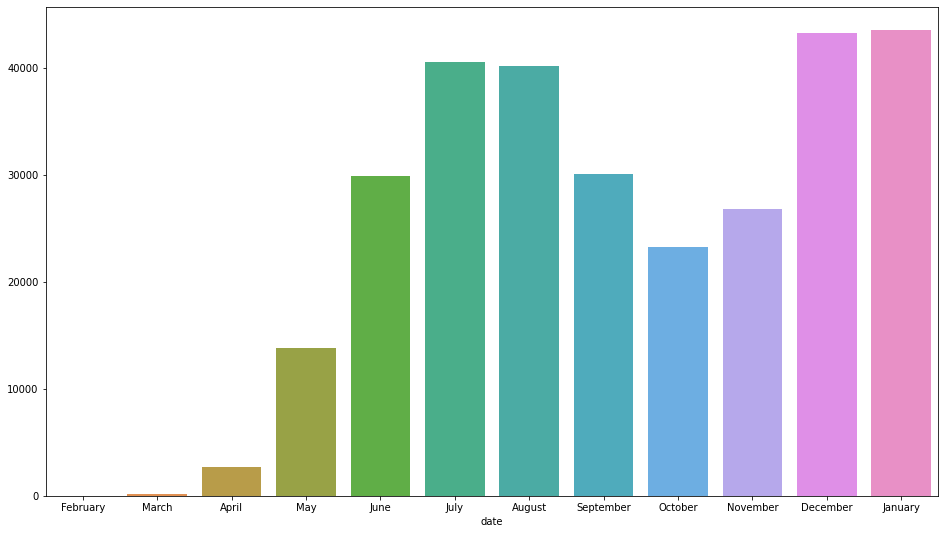

In [68]:
# Média mensal dos novos casos (gráfico de colunas)
sns.barplot(x = novos_casos_mes.index.month_name(), y = novos_casos_mes.values)

In [69]:
# Média de novos casos por dia da semana
dia_da_semana = series.groupby(series.index.dayofweek).mean()

In [70]:
dia_da_semana

date
0    16880.869565
1    30088.659574
2    31164.347826
3    31944.000000
4    29208.021739
5    24180.326087
6    14216.717391
Name: newCases, dtype: float64

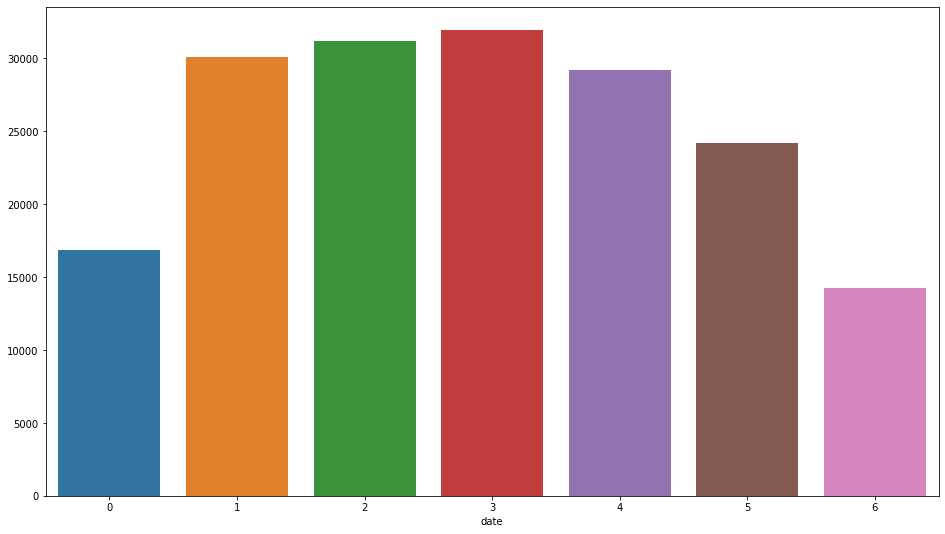

In [71]:
# Média de novos casos por dia da semana
pyplot.figure(figsize = (16,9))
sns.barplot(x = dia_da_semana.index, y = dia_da_semana.values)

In [72]:
# Média de novos casos por dia do mês
dia_do_mes = series.groupby(series.index.day).mean()

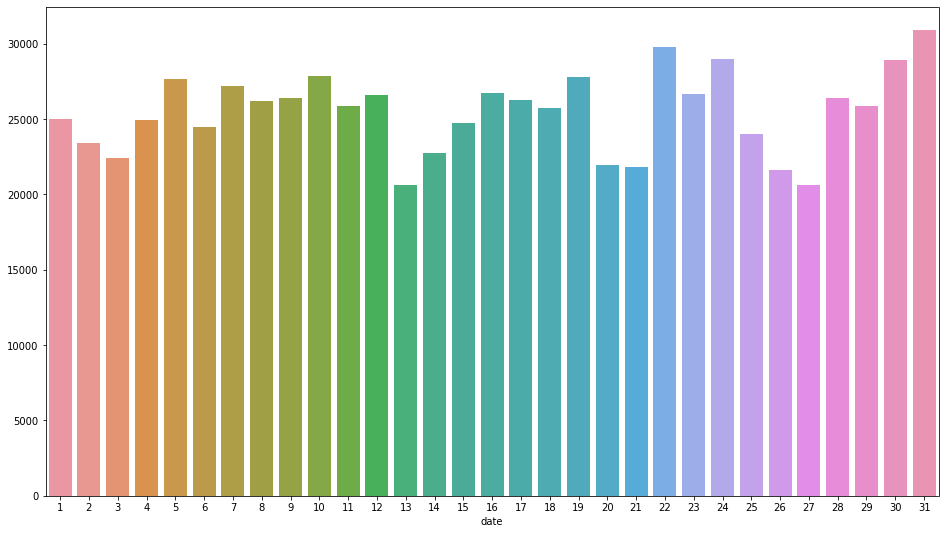

In [73]:
# Média de novos casos por dia do mês
pyplot.figure(figsize = (16,9))
sns.barplot(x = dia_do_mes.index, y = dia_do_mes.values)

### Média Móvel

In [74]:
# cria um objeto rolling de janela igual a 7
rolling = series.rolling(window=7)

In [75]:
# calcula a média da janela
rolling_mean = rolling.mean()

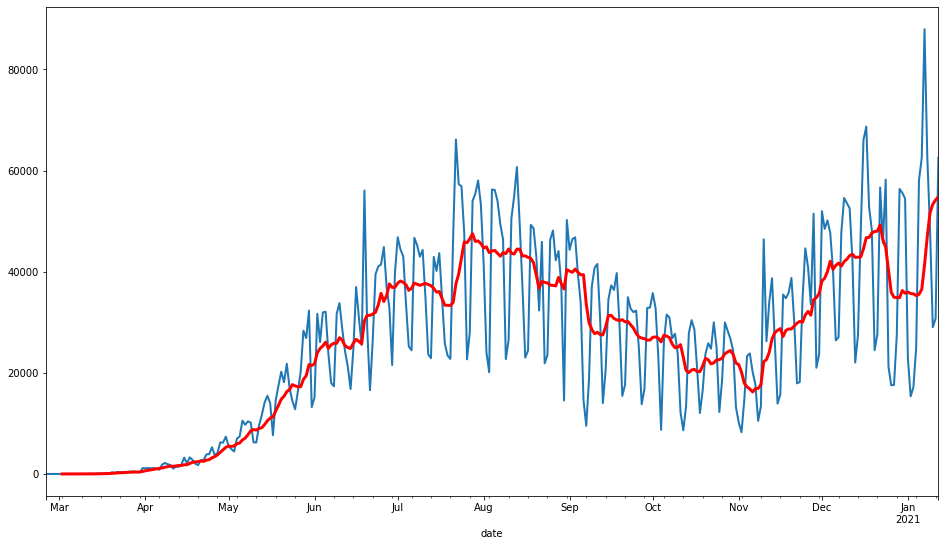

In [76]:
# plot os dados originais e os dados da média móvel
series.plot(figsize=(16,9),
            fontsize=10,
            linewidth=2)
rolling_mean.plot(color='red', linewidth=3)

### Previsão de novos casos com Média Móvel - Baseline

In [77]:
# Define uma variavel chamada X que é a copia da serie de dados
X = series.values

# Define a variável window = 7 que será a janela de 7 valores
window = 7

# Obtem os 7 primeiros valores da serie
history = [X[i] for i in range(window)]

# Obtem todos os valores após os 7 primeiros.
test = [X[i] for i in range(window, len(X))]

# cria lista de predições
predicoes = []

# Intera sobre os dados de teste...
for t in range(len(test)):
  # define a variavel length com o tamanho da variável history
  length = len(history)
  
  # define a variável valor_predito com a média dos 7 valores correntes..                                                           
  valor_predito = np.mean([history[i] for i in range(length - window, length)])        
  
  # define a variável valor_real com o valor atual do teste..
  valor_real = test[t]                                                              
  
  # alimenta a lista de predicoes
  predicoes.append(valor_predito)                                                  
  
  # atualiza a lista history com os valores correntes..
  history.append(valor_real)                                                        
  
  # imprime o valor predito e o real...
  print('Valor predito=%f, Valor real=%f' % (valor_predito, valor_real))                 

Valor predito=0.285714, Valor real=0.000000
Valor predito=0.142857, Valor real=1.000000
Valor predito=0.285714, Valor real=4.000000
Valor predito=0.857143, Valor real=7.000000
Valor predito=1.714286, Valor real=5.000000
Valor predito=2.428571, Valor real=6.000000
Valor predito=3.285714, Valor real=0.000000
Valor predito=3.285714, Valor real=9.000000
Valor predito=4.571429, Valor real=19.000000
Valor predito=7.142857, Valor real=36.000000
Valor predito=11.714286, Valor real=17.000000
Valor predito=13.142857, Valor real=36.000000
Valor predito=17.571429, Valor real=90.000000
Valor predito=29.571429, Valor real=56.000000
Valor predito=37.571429, Valor real=54.000000
Valor predito=44.000000, Valor real=191.000000
Valor predito=68.571429, Valor real=138.000000
Valor predito=83.142857, Valor real=331.000000
Valor predito=128.000000, Valor real=224.000000
Valor predito=154.857143, Valor real=396.000000
Valor predito=198.571429, Valor real=358.000000
Valor predito=241.714286, Valor real=303.00

In [78]:
# calcula a métrica de rmse
rmse = np.sqrt(mean_squared_error(test, predicoes))     

In [79]:
# imprime o valor de rmse
print('RMSE: %.3f' % rmse)

RMSE: 10602.460


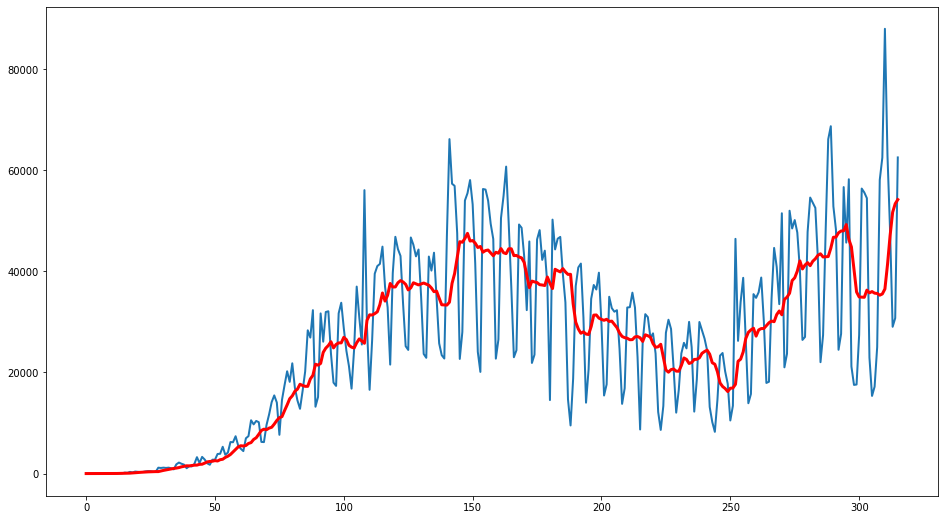

In [80]:
# plot o valor real (test) e as predições 
pyplot.figure(figsize = (16,9))
pyplot.plot(test, linewidth=2) 
pyplot.plot(predicoes, color='red', linewidth=3)
pyplot.show()

### Previsão de novos casos com Média Móvel - Divisão entre treino e teste

In [81]:
# atribui os dados a variável X 
X = series.values

In [82]:
# define o tamanho do conjunto de treino (10% dos dados para treino e teste)
train_size = int(len(X) * 0.10)

In [83]:
# cria os conjuntos de treino e teste
train = X[0:train_size]
test = X[train_size:]

In [84]:
# obtem todos os dados do treino 
history = [x for x in train]

# cria lista de previsões
predictions = list()

# aplicando o modelo naive
for i in range(len(test)):
  
  # valor_predito recebe os últimos 7 valores do conjunto de treino
  valor_predito = history[-7]
  
  # a primeira previsão é o 7º valor do conjunto de treino
  predictions.append(valor_predito)
  
  # valor real recebe o valor atual do teste.
  valor_real = test[i]
  
  # adiciona o valor real para a lista de historico
  history.append(valor_real)
  
  # imprime valor predito e valor real
  print('Valor Predito=%.3f, Valor }Esperado=%3.f' % (valor_predito, valor_real))

Valor Predito=224.000, Valor }Esperado=479
Valor Predito=396.000, Valor }Esperado=360
Valor Predito=358.000, Valor }Esperado=348
Valor Predito=303.000, Valor }Esperado=1162
Valor Predito=311.000, Valor }Esperado=1107
Valor Predito=424.000, Valor }Esperado=1169
Valor Predito=487.000, Valor }Esperado=1112
Valor Predito=479.000, Valor }Esperado=1169
Valor Predito=360.000, Valor }Esperado=1043
Valor Predito=348.000, Valor }Esperado=838
Valor Predito=1162.000, Valor }Esperado=1821
Valor Predito=1107.000, Valor }Esperado=2175
Valor Predito=1169.000, Valor }Esperado=1939
Valor Predito=1112.000, Valor }Esperado=1760
Valor Predito=1169.000, Valor }Esperado=1055
Valor Predito=1043.000, Valor }Esperado=1464
Valor Predito=838.000, Valor }Esperado=1412
Valor Predito=1821.000, Valor }Esperado=1909
Valor Predito=2175.000, Valor }Esperado=3242
Valor Predito=1939.000, Valor }Esperado=2082
Valor Predito=1760.000, Valor }Esperado=3296
Valor Predito=1055.000, Valor }Esperado=2778
Valor Predito=1464.000, V

In [85]:
# Avaliando os resultados
rmse = np.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 8963.852


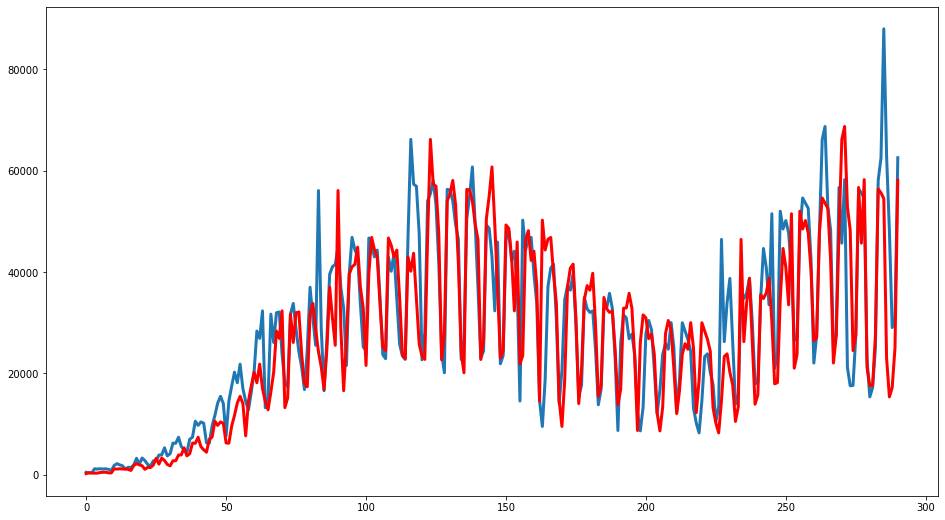

In [86]:
# plot o valor real (test) e as predições 
pyplot.figure(figsize = (16,9))
pyplot.plot(test, linewidth=3) 
pyplot.plot(predictions, color='red', linewidth=3)
pyplot.show()

### Prevendo Novos Casos com ARIMA

In [87]:
# Cria a função que faz a diferenciação
def difference(dataset, interval=7):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=7):
  return previsao + history[-interval]

In [88]:
def arima():
    # cria a variável history
    history = [x for x in train]

    # cria lista de previsões
    predictions = list()

    # inicia Walk-Forward
    for t in range(len(test)):
      
        # difference data
        qnt_dias = 7
        diff = difference(history, qnt_dias)
        
        # cria um modelo ARIMA com os dados de history
        model = ARIMA(diff, order=(7,0,1))
        
        try:
            # treina o modelo ARIMA
            model_fit = model.fit(trend='nc', disp=0)
        
            # a variável valor_predito recebe o valor previsto pelo modelo
            valor_predito = model_fit.forecast()[0]
        
            # valor_predito recebe o valor revertido (escala original)
            valor_predito = inverse_difference(history, valor_predito, qnt_dias)
        except:
            valor_predito = history[-7]
          
        # adiciona o valor predito na lista de predicões
        predictions.append(valor_predito)
        
        # a variável valor_real recebe o valor real do teste
        valor_real = test[t]
        
        # adiciona o valor real a variável history
        history.append(valor_real)

        # imprime valor predito e valor real
        print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))
        
    return predictions

In [89]:
# Predição novos casos com o arima
predicao_novos_casos = arima()

Valor predito=224.000, Valor esperado=479
Valor predito=396.000, Valor esperado=360
Valor predito=358.000, Valor esperado=348
Valor predito=303.000, Valor esperado=1162
Valor predito=311.000, Valor esperado=1107
Valor predito=424.000, Valor esperado=1169
Valor predito=487.000, Valor esperado=1112
Valor predito=479.000, Valor esperado=1169
Valor predito=360.000, Valor esperado=1043
Valor predito=348.000, Valor esperado=838
Valor predito=1162.000, Valor esperado=1821
Valor predito=1107.000, Valor esperado=2175
Valor predito=1169.000, Valor esperado=1939
Valor predito=1112.000, Valor esperado=1760
Valor predito=1169.000, Valor esperado=1055
Valor predito=1150.743, Valor esperado=1464
Valor predito=1328.970, Valor esperado=1412
Valor predito=2422.626, Valor esperado=1909
Valor predito=2326.196, Valor esperado=3242
Valor predito=1939.000, Valor esperado=2082
Valor predito=1760.000, Valor esperado=3296
Valor predito=1055.000, Valor esperado=2778
Valor predito=1464.000, Valor esperado=2022
Va

In [90]:
# Avaliando os resultados
rmse = np.sqrt(mean_squared_error(test, predicao_novos_casos))
print('Novos Casos ARIMA RMSE: %.3f' % rmse)

Novos Casos ARIMA RMSE: 7610.614


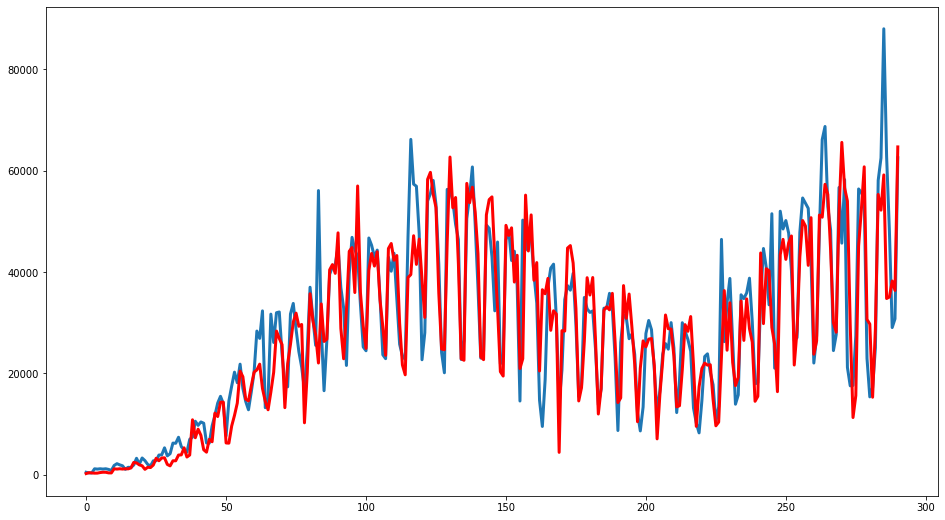

In [91]:
# plot o valor real (test) e as predições
pyplot.figure(figsize = (16,9))
pyplot.plot(test, linewidth=3)
pyplot.plot(predicao_novos_casos, color='red', linewidth=3)
pyplot.show()

8635.875  ---> 50% (7,0,1)

8602.284  ---> 50% (7,1,3)

10518.537 ---> 50% (7,0,7)

8616.187 ---> 35%

8459.469 ---> 30%

8314.112 ---> 25%

8079.985 ---> 20%

**7610.312 ---> 10% (7,0,1)**

7723.001 ---> 10% (7,0,0)

9070.868 ---> 10% (7,0,7)

7788.635 ---> 10% (7,1,1) (+ ~140)

### Prevendo Novas Mortes com ARIMA

In [92]:
# Dados de novas mortes
dataframe_novas_mortes = dataframe[["date", "newDeaths"]].set_index("date")
series = dataframe_novas_mortes["newDeaths"]
series

date
2020-02-25       0
2020-02-26       0
2020-02-27       0
2020-02-28       0
2020-02-29       0
              ... 
2021-01-08    1107
2021-01-09     983
2021-01-10     490
2021-01-11     491
2021-01-12    1085
Name: newDeaths, Length: 323, dtype: int64

In [93]:
# Análise de novas mortes por mês
resample = series.resample('M')
novas_mortes_mes = resample.mean()

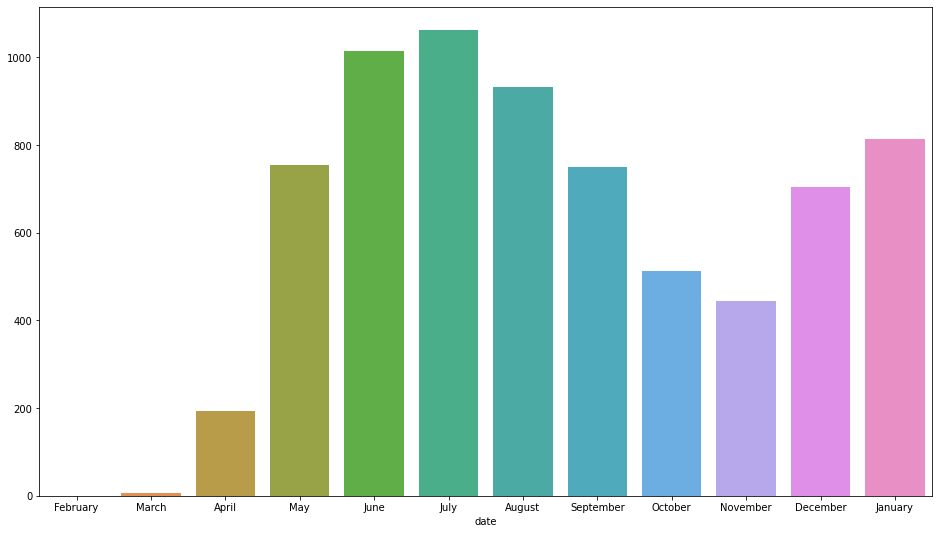

In [94]:
# Média mensal dos novos casos (gráfico de colunas)
sns.barplot(x = novas_mortes_mes.index.month_name(), y = novas_mortes_mes.values)

In [95]:
# atribui os dados a variável X 
X = series.values

In [96]:
# define o tamanho do conjunto de treino (10% dos dados para treino e teste)
train_size = int(len(X) * 0.10)

In [97]:
# cria os conjuntos de treino e teste
train = X[0:train_size]
test = X[train_size:]

In [98]:
# Predição novas mortes com o arima
predicao_novas_mortes = arima()

Valor predito=7.000, Valor esperado= 22
Valor predito=7.000, Valor esperado= 24
Valor predito=9.000, Valor esperado= 27
Valor predito=13.000, Valor esperado= 36
Valor predito=12.000, Valor esperado= 42
Valor predito=18.000, Valor esperado= 61
Valor predito=16.000, Valor esperado= 60
Valor predito=22.000, Valor esperado= 80
Valor predito=24.000, Valor esperado= 52
Valor predito=27.000, Valor esperado= 74
Valor predito=36.000, Valor esperado=121
Valor predito=42.000, Valor esperado=135
Valor predito=61.000, Valor esperado=133
Valor predito=60.000, Valor esperado=114
Valor predito=80.000, Valor esperado= 68
Valor predito=52.000, Valor esperado= 96
Valor predito=74.000, Valor esperado=120
Valor predito=121.000, Valor esperado=201
Valor predito=135.000, Valor esperado=203
Valor predito=133.000, Valor esperado=202
Valor predito=114.000, Valor esperado=211
Valor predito=68.000, Valor esperado=202
Valor predito=96.000, Valor esperado=116
Valor predito=120.000, Valor esperado=107
Valor predito=

In [99]:
# Avaliando os resultados
rmse = np.sqrt(mean_squared_error(test, predicao_novas_mortes))
print('Novas Mortes ARIMA RMSE: %.3f' % rmse)

Novas Mortes ARIMA RMSE: 146.957


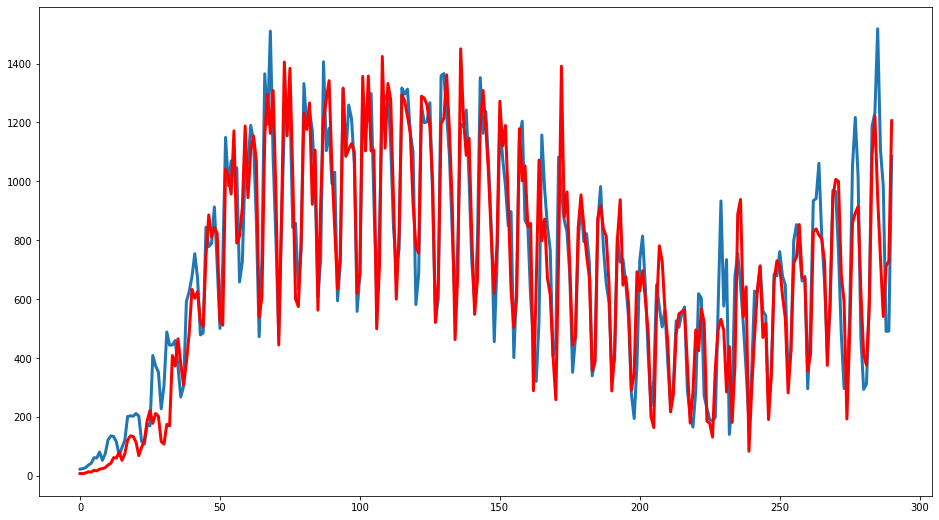

In [100]:
# plot o valor real (test) e as predições
pyplot.figure(figsize = (16,9))
pyplot.plot(test, linewidth=3)
pyplot.plot(predicao_novas_mortes, color='red', linewidth=3)
pyplot.show()